In [572]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load data
S = np.load('G:\DATA\MESO\TX29/2018_10_05\suite2p\combined/spks.npy')
iscell = np.load('G:\DATA\MESO\TX29/2018_10_05/suite2p\combined/iscell.npy')
S = S[iscell[:,0].astype(bool),:]

S -= np.mean(S, axis=1)[:, np.newaxis]
S /= np.std(S)

# rastermap algorithm
import sys
sys.path.insert(0, 'D:/Github/rastermap/rastermap/')
from mapping import map
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.sparse.linalg import eigsh
from scipy.stats import zscore
import numpy as np
import time

# run rastermap 
# (will take ~ 30s for 6000 neurons x 20000 timepts on a laptop)
# these are the default options, you can change them and input them to the function
ops = {'nclust': 30, # number of clusters
       'iPC': np.arange(0,200).astype(np.int32), # number of PCs to use for mapping algorithm
       'upsamp': 100, # upsampling factor for embedding position
       'sigUp': 1, # standard deviation for kriging upsampling
       'equal': False, # whether or not clusters should be of equal size (recommended False!)       
       'dims': 1,
       }
# user options

nmin = min([S.shape[0],S.shape[1]])
nmin = np.minimum(nmin-1, ops['iPC'].max()+1)
sv,u = eigsh(S @ S.T, k=nmin)
u = u[:, ::-1]
sv = sv[::-1]
sv = sv**0.5
v = S.T @ u
vn = v / ((v**2).sum(axis=0))**.5

isort2,iclust2 = map(S.T,ops,v,sv)
Sm = gaussian_filter1d(S[:, isort2],3,axis=1)
#Sm = gaussian_filter1d((S,3,axis=1)
isort1,iclust1 = map(Sm,ops,u,sv)
Sraw = S

18254383000000.0
21038165000000.0
21491297000000.0
21708200000000.0
21879532000000.0
22031234000000.0
22174482000000.0
22304540000000.0
22423800000000.0
22540475000000.0
22660336000000.0
22779865000000.0
22899914000000.0
23027614000000.0
23159623000000.0
23299046000000.0
23440115000000.0
23585651000000.0
23734160000000.0
23884462000000.0
24040733000000.0
24198274000000.0
24366180000000.0
24544555000000.0
24726267000000.0
24911112000000.0
25093458000000.0
25271320000000.0
25442032000000.0
25617477000000.0
25786094000000.0
25948146000000.0
26110719000000.0
26269647000000.0
26424750000000.0
26578076000000.0
26727978000000.0
26885065000000.0
27039787000000.0
27189240000000.0
27340336000000.0
27495938000000.0
27656513000000.0
27833870000000.0
28017370000000.0
28196510000000.0
28367995000000.0
28542230000000.0
28724607000000.0
28918896000000.0
28956846000000.0
28974162000000.0
28983456000000.0
28990803000000.0
28997052000000.0
29000198000000.0
29002807000000.0
29004208000000.0
29004292000000

In [567]:
ndims = 1
isort = np.zeros((ndims, u.shape[0]), 'int32')
for j in range(ndims):
    isort[j] = np.argsort(u[:,j]).astype(np.int32)
    #isort[j] = np.random.permutation(NN)

iPC = ops['iPC']
S = u[:,iPC] * sv[iPC]
S -= np.mean(S, axis=0)

NN,nPC = S.shape
nclust = 60
nn = int(np.ceil(NN/nclust)) # number of neurons per cluster

iclust = np.zeros((ndims, NN), 'int32')
for j in range(ndims):
    iclust[j][isort[j]] = np.floor(np.arange(0,NN)/nn).astype(np.int32)
    
# annealing schedule for embedding
sig_anneal = np.concatenate((np.linspace(nclust/10,1,150),np.ones((50,),np.float32)), axis=0)
#sig_anneal = np.ones((501,),np.float32)
V = np.zeros((ndims, nPC,nclust), np.float32)
cmax = np.ones((ndims, NN), np.float32)

lam = 0.
niter = len(sig_anneal)
Err = np.zeros((niter, ndims))
for t in range(niter):    
    sig = sig_anneal[t]
    Srez = S.copy()
    for i in range(ndims):
        Srez -= np.transpose(V[i][:, iclust[i]] * cmax[i])

        
    for i in range(ndims):
        Srez += np.transpose(V[i][:, iclust[i]] * cmax[i])
        for j in range(nclust):
            iin = iclust[i]==j
            V[i][:,j] = (Srez[iin,:]* cmax[i][iin][:, np.newaxis]).sum(axis=0)
            #V[i][:,j] = Srez[iin,:].sum(axis=0)        
        
        V[i] = gaussian_filter1d(V[i], sig, axis=1,mode='wrap') # smooth activity across clusters        
        
        V[i] /= ((V[i]**2).sum(axis=0))**0.5 # normalize columns to unit norm
        
        cv = Srez @ V[i] # reproject onto activity across neurons        
        
        iclust[i] = np.argmax(cv, axis=1) # recompute best clusters
        
        cmax[i] = cv[np.arange(NN), iclust[i]]
        if t<niter-1:
            cmax[i] = cmax[i] / (1.+lam)
        
        Srez -= np.transpose(V[i][:, iclust[i]] * cmax[i])
        
        Err[t,i] = np.mean(Srez**2)

    
    # S = np.linalg.solve(np.concatenate((V[0][:, iclust[0]], V[1][:, iclust[1]]), axis=0), S )
        
    if t==niter-1 or np.remainder(t,100)==0:
        print(t, np.mean(Srez**2))    
    if t==niter-1 or np.remainder(t,100)==0:
        print(t, np.mean(cmax**2))    
NT = vn.shape[0]
Vfull = np.zeros((ndims, NT, nclust))
for i in range(ndims):
    Vfull[i] = vn @ V[i]    

0 57.159447
0 530.12085
100 47.805347
100 2400.9426
199 41.29858
199 3702.291


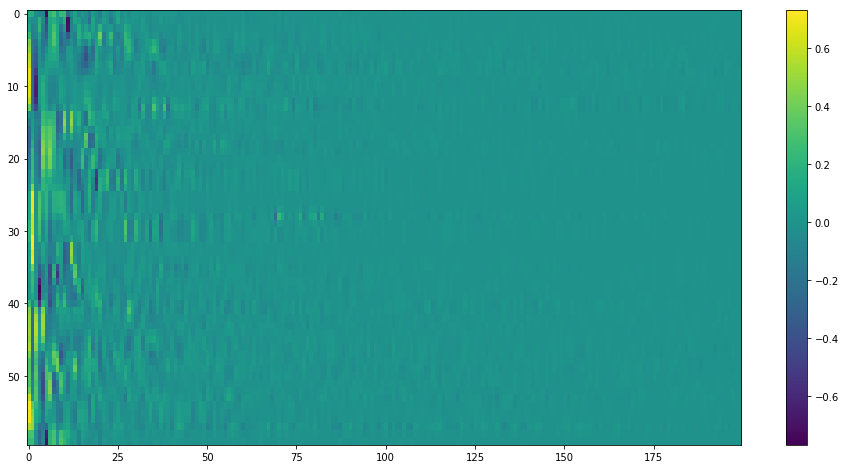

In [568]:
plt.figure(figsize=(16,8))
plt.imshow(V[0].T, aspect = 'auto')
plt.colorbar()
plt.show()

In [540]:
Sr = np.zeros((ndims, NN, nPC))
for i in range(ndims):
    Sr[i] = np.transpose(V[i][:, iclust[i]] * cmax[i])    

np.corrcoef(Sr[1][12,:], Sr[0][12,:])

array([[1.        , 0.10655207],
       [0.10655207, 1.        ]])

In [541]:
Srez = Sraw.copy()
print(np.mean(Srez**2))
for i in range(ndims):    
    Srez -= np.transpose(Vfull[i][:, iclust[i]] * cmax[i])
print(np.mean(Srez**2))    

0.99999213
0.74896634


In [573]:
j = 0
#Sm = np.transpose(Vfull[j][:, iclust[j]] * cmax[j])
Sm = Sraw.copy()

#isort1 = isort[j]

Sm = gaussian_filter1d(Sm[isort1,:].T, np.minimum(10,int(Sraw.shape[0]*0.005)), axis=1)
Sm = Sm.T
Sm = zscore(Sm, axis=1)

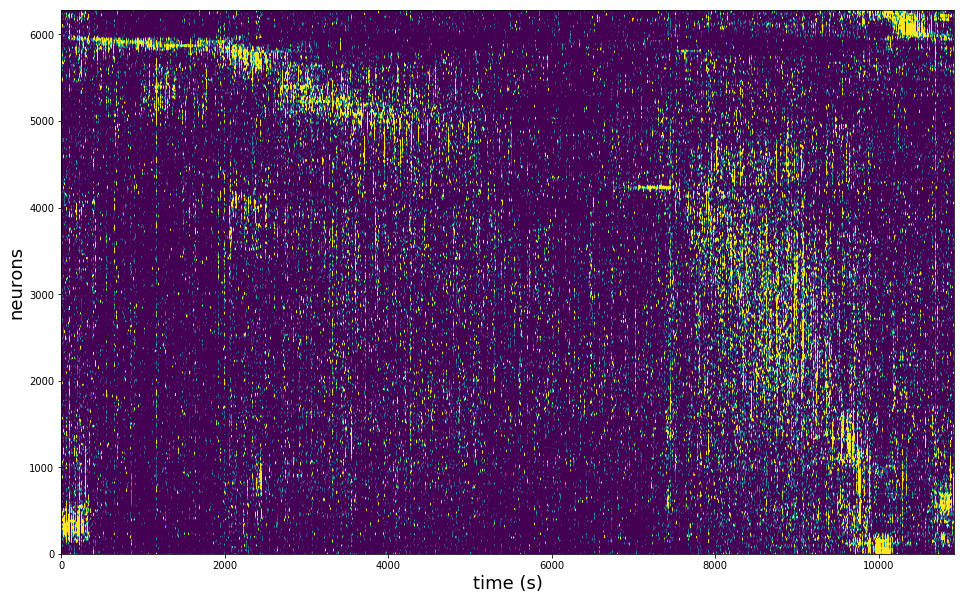

In [575]:
# view neuron sorting
fs = 2.5 # sampling rate of data in Hz
sp = Sm[:,isort2]
plt.figure(figsize=(16,10))
ax=plt.imshow(sp,vmin=0,vmax=2,aspect='auto',extent=[0,sp.shape[1]/fs, 0,sp.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
plt.show()

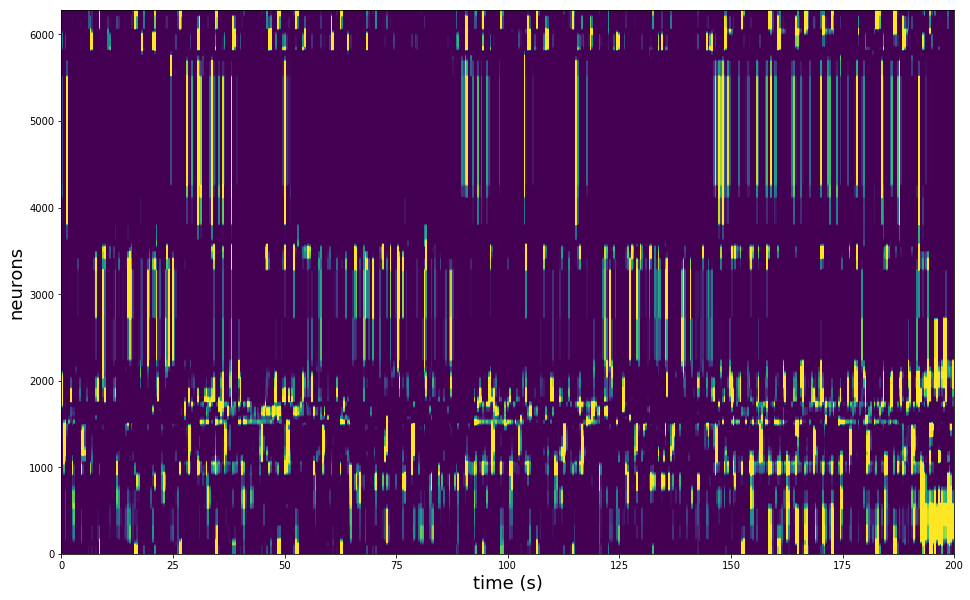

In [551]:
# view neuron sorting
fs = 2.5 # sampling rate of data in Hz
sp = Sm[:,1500:2000]
plt.figure(figsize=(16,10))
ax=plt.imshow(sp,vmin=0,vmax=2,aspect='auto',extent=[0,sp.shape[1]/fs, 0,sp.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
plt.show()


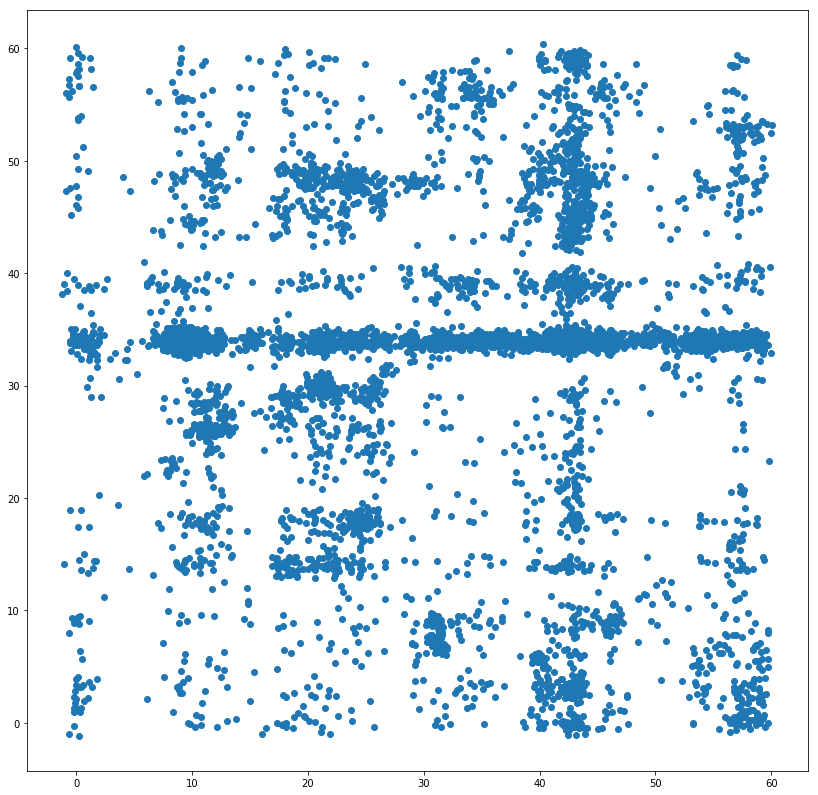

In [517]:
plt.figure(figsize=(14, 14))
plt.scatter(iclust[1]+np.random.randn(NN)*.5, iclust[0]+np.random.randn(NN)*.5)
#plt.plot(np.sort(iclust[0]))
plt.show()